In [1]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import timedelta
from selenium import webdriver
from bs4 import BeautifulSoup
from itertools import chain
from selenium.webdriver.firefox.options import Options

In [2]:
urls = {
    'switzerland' : {
        '2022' : 'https://www.coachcox.co.uk/imstats/race/1887/results/',
        '2021' : 'https://www.coachcox.co.uk/imstats/race/1793/results/',
        '2019' : 'https://www.coachcox.co.uk/imstats/race/485/results/',
        '2018' : 'https://www.coachcox.co.uk/imstats/race/437/results/'
    },
    'copenhagen' : {
        '2022' : 'https://www.coachcox.co.uk/imstats/race/1880/results/',
        '2021' : 'https://www.coachcox.co.uk/imstats/race/1776/results/', 
        '2019' : 'https://www.coachcox.co.uk/imstats/race/492/results/', 
        '2018' : 'https://www.coachcox.co.uk/imstats/race/443/results/'
    }
}

In [3]:
def scrape(url):
    """
    Function takes a URL from www.coachcox.co.uk and scrapes the results data. Returns a DF containing the results 
    """
    # Set up webdriver and get the content
    options = Options()
    options.add_argument("--headless")
    driver = webdriver.Firefox(options=options)
    driver.get(url)
    html = driver.page_source

    # Parse the html and locate the results table
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find('table', id='imraceresultstable')

    # Grab the results and column titles from the table
    data = []
    labels = []
    for row in table.find_all('tr'):
        data_cells = row.find_all('td')
        data.append([cell.text for cell in data_cells])

        lebel_cells = row.find_all('th')
        labels.append([cell.text for cell in lebel_cells])

    # Flatten the list of labels
    labels = list(chain.from_iterable(labels))

    return pd.DataFrame(data, columns=labels)

In [4]:
def scrape_all_to_file(urls):
    for country, dates in urls.items():
        for date, url in dates.items(): 
            filename = f"dataFiles/{country}_{date}.res"
            df = scrape(url)
            df.to_pickle(filename)


In [5]:
# scrape_all_to_file(urls)

In [6]:
dataFiles = os.listdir("dataFiles")
dataFiles

['copenhagen_2018.res',
 'copenhagen_2019.res',
 'switzerland_2019.res',
 'switzerland_2018.res',
 'copenhagen_2022.res',
 'switzerland_2022.res',
 'switzerland_2021.res',
 'copenhagen_2021.res']

In [7]:
df = pd.read_pickle('dataFiles/copenhagen_2022.res')

In [8]:
# Remove top row (contains Nones)
df = df[1:]
# Put swim times in consistant format 
df['Swim Time'] = df['Swim Time'].apply(lambda x: '00:' + x if len(x.split(':')) < 3 else x)

In [9]:
# Convert time columns to duration
df['Swim Time'] = pd.to_timedelta(df['Swim Time'],errors='coerce')
df['Bike Time'] = pd.to_timedelta(df['Bike Time'])
df['Run Time'] = pd.to_timedelta(df['Run Time'])


In [10]:
df

,Bib,Name,Country,Gender,Division,Division Rank,Overall Time,Overall Rank,Swim Time,Swim Rank,Bike Time,Bike Rank,Run Time,Run Rank,Finish Status
1,2141,Benjamin Winkler,Germany,Male,M35-39,1,8:19:20,1,0 days 00:54:25,25,0 days 04:29:27,13,0 days 02:49:29,3,Finisher
2,73,Lars Petter Stormo,Norway,Male,M40-44,1,8:27:43,2,0 days 00:53:55,20,0 days 04:31:03,20,0 days 02:57:34,7,Finisher
3,667,Chris Weeks,United Kingdom,Male,M30-34,1,8:31:26,3,0 days 00:57:16,79,0 days 04:32:06,24,0 days 02:54:59,4,Finisher
4,12,Lee Williams,United Kingdom,Male,M40-44,2,8:31:26,4,0 days 00:53:58,21,0 days 04:30:47,18,0 days 03:01:04,10,Finisher
5,869,Alexander Beck,Germany,Male,M30-34,2,8:32:33,5,0 days 00:59:18,128,0 days 04:25:56,5,0 days 02:55:59,5,Finisher
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,2320,Denis Berckmans,Belgium,Male,M45-49,,,,0 days 01:19:37,1436,0 days 07:27:47,2132,NaT,,DNF
2333,2131,Lício Eduardo Oliveira,Brazil,Male,M40-44,,,,0 days 01:20:29,1511,NaT,,NaT,,DNF
2334,1991,Julie Niewald Anhøj,Denmark,Female,F25-29,,,,0 days 01:36:44,2070,NaT,,NaT,,DNF
2335,1413,James Gunn,United Kingdom,Male,M45-49,,,,0 days 02:09:21,2195,NaT,,NaT,,DNF


In [11]:
def calculate_bike_speed(bike_time):
    """Calculate the speed in km/h for IM bike duration"""

    bike_distance = 180.2 # 112mile, 180.2km 

    bike_speed_kms = bike_distance / bike_time.total_seconds()

    bike_speed_kmh = bike_speed_kms * 3600

    return bike_speed_kmh    

In [12]:
def calculate_pace(time, distance):
    """Calculate the pace of given time/ distance""" 

    if pd.isnull(time):
        return np.nan

    time = time.total_seconds() / 60 # Minutes

    pace = time / distance

    return timedelta(minutes=int(pace), seconds=int((pace % 1) * 60))

In [13]:
df['Swim Pace'] = df['Swim Time'].apply(calculate_pace, args=(39,)) # 39 lots of 100m in 3.9k, will give answer in min/100m
df['Run Pace'] = df['Run Time'].apply(calculate_pace, args=(26.2,)) # 26.2 miles, pace in minutes per mile 
df['Bike Speed'] = df['Bike Time'].apply(calculate_bike_speed)

In [14]:
wardy = df[df.apply(lambda r: r.str.contains('Medhurst', case=False).any(), axis=1)] 

In [15]:
wardy

,Bib,Name,Country,Gender,Division,Division Rank,Overall Time,Overall Rank,Swim Time,Swim Rank,Bike Time,Bike Rank,Run Time,Run Rank,Finish Status,Swim Pace,Run Pace,Bike Speed
1677,485,Cam Medhurst,United Kingdom,Male,M25-29,117,13:14:00,1677,0 days 01:13:48,960,0 days 06:20:06,1769,0 days 05:22:36,1685,Finisher,0 days 00:01:53,0 days 00:12:18,28.445146


In [16]:
run_bike = df[['Bib', 'Bike Speed', 'Run Pace']]
run_bike['Run Pace'] = run_bike['Run Pace'].apply(lambda x: x.total_seconds() / 60)
run_bike = run_bike.dropna()
run_bike

/tmp/ipykernel_37435/2268592386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_bike['Run Pace'] = run_bike['Run Pace'].apply(lambda x: x.total_seconds() / 60)


,Bib,Bike Speed,Run Pace
1,2141,40.126183,6.466667
2,73,39.889319,6.766667
3,667,39.735391,6.666667
4,12,39.928602,6.900000
5,869,40.656806,6.716667
...,...,...,...
2200,652,26.064526,12.100000
2208,248,30.449190,12.933333
2209,403,32.281051,5.900000
2261,755,24.468920,13.016667


In [17]:
run_bike

,Bib,Bike Speed,Run Pace
1,2141,40.126183,6.466667
2,73,39.889319,6.766667
3,667,39.735391,6.666667
4,12,39.928602,6.900000
5,869,40.656806,6.716667
...,...,...,...
2200,652,26.064526,12.100000
2208,248,30.449190,12.933333
2209,403,32.281051,5.900000
2261,755,24.468920,13.016667


In [18]:
wardy = run_bike.loc[run_bike['Bib'] == '485']
wardy

,Bib,Bike Speed,Run Pace
1677,485,28.445146,12.3


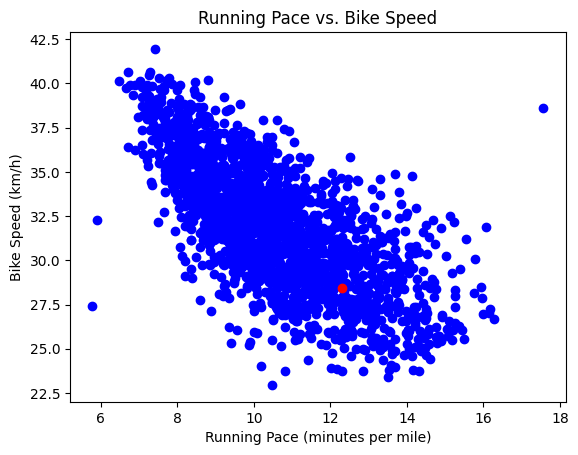

In [19]:
plt.scatter(run_bike['Run Pace'], run_bike['Bike Speed'],c='blue')
plt.scatter(wardy['Run Pace'], wardy['Bike Speed'],c='red')


plt.xlabel('Running Pace (minutes per mile)')
plt.ylabel('Bike Speed (km/h)')
plt.title('Running Pace vs. Bike Speed')


plt.show()